# PeopleRX: Drug Recommendation System (Part 1)

# import in libraries

In [1]:
import nltk
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import re, string
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity

# combine train & test data into one dataframe

In [2]:
df_train = pd.read_table("C:/Users/New User/Desktop/NLP/drugsCom_raw/drugsComTrain_raw.tsv")
df_test = pd.read_table("C:/Users/New User/Desktop/NLP/drugsCom_raw/drugsComTest_raw.tsv")

df_main = pd.concat([df_train, df_test], axis=0)
df_main.head(3)

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17


In [3]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215063 entries, 0 to 53765
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   215063 non-null  int64  
 1   drugName     215063 non-null  object 
 2   condition    213869 non-null  object 
 3   review       215063 non-null  object 
 4   rating       215063 non-null  float64
 5   date         215063 non-null  object 
 6   usefulCount  215063 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 13.1+ MB


In [4]:
df_main.nunique()

Unnamed: 0     215063
drugName         3671
condition         916
review         131932
rating             10
date             3579
usefulCount       397
dtype: int64

# Pre-processing: RegEx to remove numbers, capital letters, and punctuations in reviews

In [8]:
# Text preprocessing steps - remove numbers, capital letters, and punctuations

alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', str(x))
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
df_main['review']= df_main['review'].map(alphanumeric).map(punc_lower)
df_main.review.head()

0    it has no side effect i take it in combination...
1    my son is halfway through his fourth week of i...
2    i used to take another oral contraceptive whic...
3    this is my first time using any form of birth ...
4    suboxone has completely turned my life around ...
Name: review, dtype: object

In [9]:
df_main.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,it has no side effect i take it in combination...,9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,my son is halfway through his fourth week of i...,8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,i used to take another oral contraceptive whic...,5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,this is my first time using any form of birth ...,8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,suboxone has completely turned my life around ...,9.0,"November 27, 2016",37


# Pre-processing: Inspecting for rows with NaN values and dropping them

In [11]:
df_main.describe(include='all') # There are NaN values in df

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
count,215063.000000,215063,213869,215063,215063.000000,215063,215063.000000
unique,NaN,3671,916,129191,NaN,3579,NaN
top,NaN,Levonorgestrel,Birth Control,good,NaN,"March 1, 2016",NaN
freq,NaN,4930,38436,74,NaN,185,NaN
mean,116039.364814,NaN,NaN,NaN,6.990008,NaN,28.001004
std,67007.913366,NaN,NaN,NaN,3.275554,NaN,36.346069
min,0.000000,NaN,NaN,NaN,1.000000,NaN,0.000000
25%,58115.500000,NaN,NaN,NaN,5.000000,NaN,6.000000
50%,115867.000000,NaN,NaN,NaN,8.000000,NaN,16.000000
75%,173963.500000,NaN,NaN,NaN,10.000000,NaN,36.000000


In [19]:
# list of columns with NaN
df_main.columns[df_main.isna().any()].tolist()

['condition']

In [20]:
# selecting columns containing at least one NaN value

df_main.loc[:, df_main.isna().any()]

,condition
0,Left Ventricular Dysfunction
1,ADHD
2,Birth Control
3,Birth Control
4,Opiate Dependence
...,...
53761,"Breast Cancer, Prevention"
53762,Anxiety
53763,Birth Control
53764,Pain


In [22]:
df_main.isnull().sum() # there are 1194 nulls in condition column

Unnamed: 0        0
drugName          0
condition      1194
review            0
rating            0
date              0
usefulCount       0
dtype: int64

In [23]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215063 entries, 0 to 53765
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   215063 non-null  int64  
 1   drugName     215063 non-null  object 
 2   condition    213869 non-null  object 
 3   review       215063 non-null  object 
 4   rating       215063 non-null  float64
 5   date         215063 non-null  object 
 6   usefulCount  215063 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 13.1+ MB


In [24]:
df_main.nunique()

Unnamed: 0     215063
drugName         3671
condition         916
review         129191
rating             10
date             3579
usefulCount       397
dtype: int64

In [28]:
# Since there are 1,194 rows with NaN values out of 215,063 rows, 
# those 1,194 NaN rows will be dropped

df_NaN = df_main[df_main['condition'].isna() == True]
df_main = df_main.drop(df_NaN.index, axis=0)
df_main.isnull().sum()

Unnamed: 0     0
drugName       0
condition      0
review         0
rating         0
date           0
usefulCount    0
dtype: int64

In [29]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213248 entries, 0 to 53765
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   213248 non-null  int64  
 1   drugName     213248 non-null  object 
 2   condition    213248 non-null  object 
 3   review       213248 non-null  object 
 4   rating       213248 non-null  float64
 5   date         213248 non-null  object 
 6   usefulCount  213248 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 13.0+ MB


In [30]:
df_main

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,it has no side effect i take it in combination...,9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,my son is halfway through his fourth week of i...,8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,i used to take another oral contraceptive whic...,5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,this is my first time using any form of birth ...,8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,suboxone has completely turned my life around ...,9.0,"November 27, 2016",37
...,...,...,...,...,...,...,...
53761,159999,Tamoxifen,"Breast Cancer, Prevention",i have taken tamoxifen for years side effects ...,10.0,"September 13, 2014",43
53762,140714,Escitalopram,Anxiety,ive been taking lexapro escitaploprgram since ...,9.0,"October 8, 2016",11
53763,130945,Levonorgestrel,Birth Control,im married years old and i have no kids taking...,8.0,"November 15, 2010",7
53764,47656,Tapentadol,Pain,i was prescribed nucynta for severe neckshould...,1.0,"November 28, 2011",20


# Pre-processing: Dropping long reviews

In [31]:
df_main.review

0        it has no side effect i take it in combination...
1        my son is halfway through his fourth week of i...
2        i used to take another oral contraceptive whic...
3        this is my first time using any form of birth ...
4        suboxone has completely turned my life around ...
                               ...                        
53761    i have taken tamoxifen for years side effects ...
53762    ive been taking lexapro escitaploprgram since ...
53763    im married years old and i have no kids taking...
53764    i was prescribed nucynta for severe neckshould...
53765                                             it works
Name: review, Length: 213248, dtype: object

82.9001069177671
1881


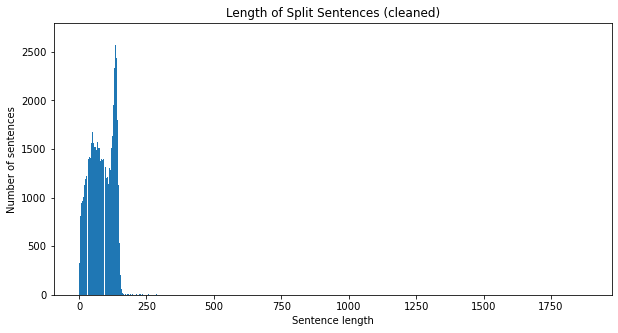

In [32]:
print(df_main['review'].str.split().str.len().mean())
print(df_main['review'].str.split().str.len().max())
df_main["strlen"] = df_main['review'].str.split().str.len()
df_main.describe()

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 5)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.title('Length of Split Sentences (cleaned)')
plt.hist(df_main["strlen"], bins=1941)
plt.show()

In [33]:
# Exploring distribution of words here

_a = df_main.loc[df_main["strlen"] >= 1000].strlen.count()
_b = df_main.loc[df_main["strlen"] >= 750].strlen.count()
_c = df_main.loc[df_main["strlen"] >= 250].strlen.count()
_d = df_main.loc[df_main["strlen"] >= 180].strlen.count()
_e = df_main.loc[df_main["strlen"] >= 100].strlen.count()
_f = df_main.loc[df_main["strlen"] < 100].strlen.count()

print (" # of Reviews by Length \n %s >1000 words \n %s >750 words \n %s >250 words \n %s >180 words \n %s >100 words \n %s <100 words\n" % (_a,_b,_c,_d,_e,_f))

 # of Reviews by Length 
 6 >1000 words 
 10 >750 words 
 203 >250 words 
 409 >180 words 
 83927 >100 words 
 129321 <100 words



82.48525722339676
180
Max sentence length is 180


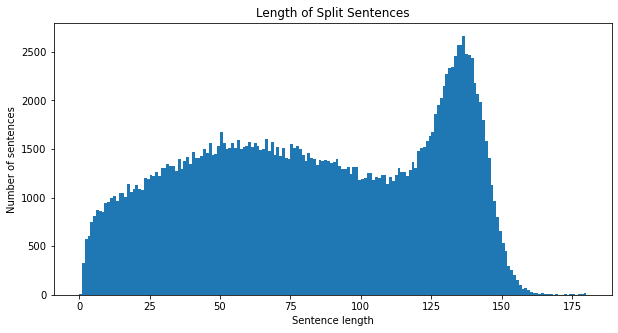

In [34]:
# Dropping long sentence outliers or long rows of comment

df_main = df_main.loc[df_main["strlen"] <= 180]
print(df_main['review'].str.split().str.len().mean())
print(df_main['review'].str.split().str.len().max())
print("Max sentence length is %s" % max(df_main["strlen"]))

#df_clean_text.describe()

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 5)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.title('Length of Split Sentences')
plt.hist(df_main["strlen"], bins=180)
plt.show()


In [35]:
# Sentence lengths after cleaning

_a = df_main.loc[df_main["strlen"] >= 1000].strlen.count()
_b = df_main.loc[df_main["strlen"] >= 750].strlen.count()
_c = df_main.loc[df_main["strlen"] >= 250].strlen.count()
_d = df_main.loc[df_main["strlen"] >= 180].strlen.count()
_e = df_main.loc[df_main["strlen"] >= 100].strlen.count()
_f = df_main.loc[df_main["strlen"] < 100].strlen.count()
print (" # of Reviews by Length \n %s >1000 words \n %s >750 words \n %s >250 words \n %s >180 words \n %s >100 words \n %s <100 words\n" % (_a,_b,_c,_d,_e,_f))

 # of Reviews by Length 
 0 >1000 words 
 0 >750 words 
 0 >250 words 
 11 >180 words 
 83529 >100 words 
 129321 <100 words



In [38]:
# final dataframe has 212,850 data points
len(df_main)

212850

In [45]:
df_main['text'] = df_main[['review']]

In [46]:
df_main.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount,strlen,tokens,text
0,206461,Valsartan,Left Ventricular Dysfunction,it has no side effect i take it in combination...,9.0,"May 20, 2012",27,16,"[it, has, no, side, effect, i, take, it, in, c...",it has no side effect i take it in combination...
1,95260,Guanfacine,ADHD,my son is halfway through his fourth week of i...,8.0,"April 27, 2010",192,140,"[my, son, is, halfway, through, his, fourth, w...",my son is halfway through his fourth week of i...
2,92703,Lybrel,Birth Control,i used to take another oral contraceptive whic...,5.0,"December 14, 2009",17,132,"[i, used, to, take, another, oral, contracepti...",i used to take another oral contraceptive whic...
3,138000,Ortho Evra,Birth Control,this is my first time using any form of birth ...,8.0,"November 3, 2015",10,86,"[this, is, my, first, time, using, any, form, ...",this is my first time using any form of birth ...
4,35696,Buprenorphine / naloxone,Opiate Dependence,suboxone has completely turned my life around ...,9.0,"November 27, 2016",37,125,"[suboxone, has, completely, turned, my, life, ...",suboxone has completely turned my life around ...


In [48]:
df_clean_text.to_csv("C:/Users/New User/Desktop/NLP/drugsCom_raw/drugs_clean_data.csv")

In [2]:
df_clean_text = pd.read_csv("C:/Users/New User/Desktop/NLP/drugsCom_raw/drugs_clean_data.csv")

In [3]:
df_clean_text.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount,strlen,tokens,text
0,0,Valsartan,Left Ventricular Dysfunction,it has no side effect i take it in combination...,9.0,"May 20, 2012",27,16,"['it', 'has', 'no', 'side', 'effect', 'i', 'ta...",it has no side effect i take it in combination...
1,1,Guanfacine,ADHD,my son is halfway through his fourth week of i...,8.0,"April 27, 2010",192,140,"['my', 'son', 'is', 'halfway', 'through', 'his...",my son is halfway through his fourth week of i...
2,2,Lybrel,Birth Control,i used to take another oral contraceptive whic...,5.0,"December 14, 2009",17,132,"['i', 'used', 'to', 'take', 'another', 'oral',...",i used to take another oral contraceptive whic...
3,3,Ortho Evra,Birth Control,this is my first time using any form of birth ...,8.0,"November 3, 2015",10,86,"['this', 'is', 'my', 'first', 'time', 'using',...",this is my first time using any form of birth ...
4,4,Buprenorphine / naloxone,Opiate Dependence,suboxone has completely turned my life around ...,9.0,"November 27, 2016",37,125,"['suboxone', 'has', 'completely', 'turned', 'm...",suboxone has completely turned my life around ...


In [4]:
df_clean_text = df_clean_text.drop(['Unnamed: 0'], axis=1)
df_clean_text.head()

,drugName,condition,review,rating,date,usefulCount,strlen,tokens,text
0,Valsartan,Left Ventricular Dysfunction,it has no side effect i take it in combination...,9.0,"May 20, 2012",27,16,"['it', 'has', 'no', 'side', 'effect', 'i', 'ta...",it has no side effect i take it in combination...
1,Guanfacine,ADHD,my son is halfway through his fourth week of i...,8.0,"April 27, 2010",192,140,"['my', 'son', 'is', 'halfway', 'through', 'his...",my son is halfway through his fourth week of i...
2,Lybrel,Birth Control,i used to take another oral contraceptive whic...,5.0,"December 14, 2009",17,132,"['i', 'used', 'to', 'take', 'another', 'oral',...",i used to take another oral contraceptive whic...
3,Ortho Evra,Birth Control,this is my first time using any form of birth ...,8.0,"November 3, 2015",10,86,"['this', 'is', 'my', 'first', 'time', 'using',...",this is my first time using any form of birth ...
4,Buprenorphine / naloxone,Opiate Dependence,suboxone has completely turned my life around ...,9.0,"November 27, 2016",37,125,"['suboxone', 'has', 'completely', 'turned', 'm...",suboxone has completely turned my life around ...


In [8]:
df_clean_text.to_csv("C:/Users/New User/Desktop/NLP/drugsCom_raw/drugs_clean_data.csv")

In [9]:
df_clean_text.head()

,drugName,condition,review,rating,date,usefulCount,strlen,tokens,text
0,Valsartan,Left Ventricular Dysfunction,it has no side effect i take it in combination...,9.0,"May 20, 2012",27,16,"['it', 'has', 'no', 'side', 'effect', 'i', 'ta...",it has no side effect i take it in combination...
1,Guanfacine,ADHD,my son is halfway through his fourth week of i...,8.0,"April 27, 2010",192,140,"['my', 'son', 'is', 'halfway', 'through', 'his...",my son is halfway through his fourth week of i...
2,Lybrel,Birth Control,i used to take another oral contraceptive whic...,5.0,"December 14, 2009",17,132,"['i', 'used', 'to', 'take', 'another', 'oral',...",i used to take another oral contraceptive whic...
3,Ortho Evra,Birth Control,this is my first time using any form of birth ...,8.0,"November 3, 2015",10,86,"['this', 'is', 'my', 'first', 'time', 'using',...",this is my first time using any form of birth ...
4,Buprenorphine / naloxone,Opiate Dependence,suboxone has completely turned my life around ...,9.0,"November 27, 2016",37,125,"['suboxone', 'has', 'completely', 'turned', 'm...",suboxone has completely turned my life around ...


# pre-processing: removing drug names from reviews. This step was not performed because of the large number of drug names. Will revisit in the future. 

# Tokenize: CountVectorizer

In [2]:
# read in cleaned data

df_clean = pd.read_csv("C:/Users/New User/Desktop/NLP/drugsCom_raw/drugs_clean_data.csv")
df_clean.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount,strlen,tokens,text
0,0,Valsartan,Left Ventricular Dysfunction,it has no side effect i take it in combination...,9.0,"May 20, 2012",27,16,"['it', 'has', 'no', 'side', 'effect', 'i', 'ta...",it has no side effect i take it in combination...
1,1,Guanfacine,ADHD,my son is halfway through his fourth week of i...,8.0,"April 27, 2010",192,140,"['my', 'son', 'is', 'halfway', 'through', 'his...",my son is halfway through his fourth week of i...
2,2,Lybrel,Birth Control,i used to take another oral contraceptive whic...,5.0,"December 14, 2009",17,132,"['i', 'used', 'to', 'take', 'another', 'oral',...",i used to take another oral contraceptive whic...
3,3,Ortho Evra,Birth Control,this is my first time using any form of birth ...,8.0,"November 3, 2015",10,86,"['this', 'is', 'my', 'first', 'time', 'using',...",this is my first time using any form of birth ...
4,4,Buprenorphine / naloxone,Opiate Dependence,suboxone has completely turned my life around ...,9.0,"November 27, 2016",37,125,"['suboxone', 'has', 'completely', 'turned', 'm...",suboxone has completely turned my life around ...


In [3]:
df_clean = df_clean.drop(['Unnamed: 0'], axis=1)
df_clean

,drugName,condition,review,rating,date,usefulCount,strlen,tokens,text
0,Valsartan,Left Ventricular Dysfunction,it has no side effect i take it in combination...,9.0,"May 20, 2012",27,16,"['it', 'has', 'no', 'side', 'effect', 'i', 'ta...",it has no side effect i take it in combination...
1,Guanfacine,ADHD,my son is halfway through his fourth week of i...,8.0,"April 27, 2010",192,140,"['my', 'son', 'is', 'halfway', 'through', 'his...",my son is halfway through his fourth week of i...
2,Lybrel,Birth Control,i used to take another oral contraceptive whic...,5.0,"December 14, 2009",17,132,"['i', 'used', 'to', 'take', 'another', 'oral',...",i used to take another oral contraceptive whic...
3,Ortho Evra,Birth Control,this is my first time using any form of birth ...,8.0,"November 3, 2015",10,86,"['this', 'is', 'my', 'first', 'time', 'using',...",this is my first time using any form of birth ...
4,Buprenorphine / naloxone,Opiate Dependence,suboxone has completely turned my life around ...,9.0,"November 27, 2016",37,125,"['suboxone', 'has', 'completely', 'turned', 'm...",suboxone has completely turned my life around ...
...,...,...,...,...,...,...,...,...,...
212845,Tamoxifen,"Breast Cancer, Prevention",i have taken tamoxifen for years side effects ...,10.0,"September 13, 2014",43,93,"['i', 'have', 'taken', 'tamoxifen', 'for', 'ye...",i have taken tamoxifen for years side effects ...
212846,Escitalopram,Anxiety,ive been taking lexapro escitaploprgram since ...,9.0,"October 8, 2016",11,132,"['ive', 'been', 'taking', 'lexapro', 'escitapl...",ive been taking lexapro escitaploprgram since ...
212847,Levonorgestrel,Birth Control,im married years old and i have no kids taking...,8.0,"November 15, 2010",7,146,"['im', 'married', 'years', 'old', 'and', 'i', ...",im married years old and i have no kids taking...
212848,Tapentadol,Pain,i was prescribed nucynta for severe neckshould...,1.0,"November 28, 2011",20,33,"['i', 'was', 'prescribed', 'nucynta', 'for', '...",i was prescribed nucynta for severe neckshould...


In [4]:
df_clean = df_clean
df_clean

,drugName,condition,review,rating,date,usefulCount,strlen,tokens,text
0,Valsartan,Left Ventricular Dysfunction,it has no side effect i take it in combination...,9.0,"May 20, 2012",27,16,"['it', 'has', 'no', 'side', 'effect', 'i', 'ta...",it has no side effect i take it in combination...
1,Guanfacine,ADHD,my son is halfway through his fourth week of i...,8.0,"April 27, 2010",192,140,"['my', 'son', 'is', 'halfway', 'through', 'his...",my son is halfway through his fourth week of i...
2,Lybrel,Birth Control,i used to take another oral contraceptive whic...,5.0,"December 14, 2009",17,132,"['i', 'used', 'to', 'take', 'another', 'oral',...",i used to take another oral contraceptive whic...
3,Ortho Evra,Birth Control,this is my first time using any form of birth ...,8.0,"November 3, 2015",10,86,"['this', 'is', 'my', 'first', 'time', 'using',...",this is my first time using any form of birth ...
4,Buprenorphine / naloxone,Opiate Dependence,suboxone has completely turned my life around ...,9.0,"November 27, 2016",37,125,"['suboxone', 'has', 'completely', 'turned', 'm...",suboxone has completely turned my life around ...
...,...,...,...,...,...,...,...,...,...
212845,Tamoxifen,"Breast Cancer, Prevention",i have taken tamoxifen for years side effects ...,10.0,"September 13, 2014",43,93,"['i', 'have', 'taken', 'tamoxifen', 'for', 'ye...",i have taken tamoxifen for years side effects ...
212846,Escitalopram,Anxiety,ive been taking lexapro escitaploprgram since ...,9.0,"October 8, 2016",11,132,"['ive', 'been', 'taking', 'lexapro', 'escitapl...",ive been taking lexapro escitaploprgram since ...
212847,Levonorgestrel,Birth Control,im married years old and i have no kids taking...,8.0,"November 15, 2010",7,146,"['im', 'married', 'years', 'old', 'and', 'i', ...",im married years old and i have no kids taking...
212848,Tapentadol,Pain,i was prescribed nucynta for severe neckshould...,1.0,"November 28, 2011",20,33,"['i', 'was', 'prescribed', 'nucynta', 'for', '...",i was prescribed nucynta for severe neckshould...


In [5]:
import random

In [6]:
from nltk.corpus import stopwords

In [7]:
# adding new words to stopword list

stop_words = nltk.corpus.stopwords.words('english')
newStopWords = ['like','just', 'ive', 'im', 'got', 'day', 'days', 'year', 'years', 'week', 'weeks', 'took', 'taking', 'taken', 'side effects', 'months', 'mg', 'also', 'would', 'yet', 'side', 'effects', 'first', 'take', 'pill', 'medication', 'time', 'get', 'month', 'went', 'ago', 'feel', 'felt', 'one', 'hours', 'using', 'started', 'dont', 'since', 'life', 'never', 'really', 'medicine', 'dose', 'much', 'still', 'doctor', 'dr', 'meds', 'back']
stop_words.extend(newStopWords)
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [8]:
from nltk.corpus import stopwords

In [9]:
# creating document-term matrix with new stopwords

cv = CountVectorizer(stop_words=stop_words, max_df = .75, min_df=.02, ngram_range=(1,3))
X = cv.fit_transform(df_clean.review)
pd.DataFrame(X.toarray(), columns=cv.get_feature_names_out())

,able,absolutely,acne,actually,almost,along,already,although,always,amazing,...,wish,within,without,work,worked,working,works,worse,worst,worth
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212845,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
212846,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
212847,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
212848,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# CountVectorizer + Latent Semantic Analysis (LSA)

In [10]:
X.shape

(212850, 304)

In [11]:
# We have to convert `.toarray()` because the vectorizer returns a sparse matrix.
# For a big corpus, we would skip the dataframe and keep the output sparse.
pd.DataFrame(X.toarray(), index=df_clean.review, columns=cv.get_feature_names_out()).reset_index().head(10)

,review,able,absolutely,acne,actually,almost,along,already,although,always,...,wish,within,without,work,worked,working,works,worse,worst,worth
0,it has no side effect i take it in combination...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,my son is halfway through his fourth week of i...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,i used to take another oral contraceptive whic...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,this is my first time using any form of birth ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,suboxone has completely turned my life around ...,0,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
5,nd day on mg started to work with rock hard er...,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,1
6,he pulled out but he cummed a bit in me i took...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,abilify changed my life there is hope i was on...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
8,i ve had nothing but problems with the kepper...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,i had been on the pill for many years when my ...,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# Acronynms: Latent Semantic Analysis (LSA) is just another name for 
#  Signular Value Decomposition (SVD) applied to Natural Language Processing (NLP)
lsa = TruncatedSVD(6)
doc_topic = lsa.fit_transform(X)
lsa.explained_variance_ratio_

array([0.02295136, 0.03296352, 0.02429417, 0.01684624, 0.0162227 ,
       0.01428382])

In [13]:
topic_word = pd.DataFrame(lsa.components_.round(3),
#              index = ["component_1","component_2"],
             columns = cv.get_feature_names_out())
topic_word

,able,absolutely,acne,actually,almost,along,already,although,always,amazing,...,wish,within,without,work,worked,working,works,worse,worst,worth
0,0.048,0.023,0.114,0.036,0.085,0.019,0.026,0.020,0.058,0.024,...,0.016,0.051,0.056,0.114,0.074,0.041,0.074,0.061,0.043,0.036
1,0.026,-0.007,-0.118,-0.003,-0.006,0.008,-0.003,-0.000,-0.020,0.001,...,0.004,0.013,0.027,0.049,0.023,0.012,0.033,0.006,-0.003,0.002
2,-0.039,-0.000,0.036,-0.016,-0.017,-0.009,-0.016,-0.007,-0.017,-0.015,...,-0.009,-0.028,-0.038,-0.114,-0.060,-0.040,-0.054,-0.025,0.006,-0.010
3,0.003,-0.003,-0.082,0.006,-0.007,-0.002,0.004,-0.000,0.001,-0.003,...,-0.003,-0.018,-0.007,-0.038,-0.031,0.008,-0.027,-0.046,-0.020,-0.003
4,0.013,0.005,-0.007,0.002,-0.020,0.005,-0.003,-0.001,-0.001,0.003,...,0.001,-0.015,0.007,-0.007,-0.005,0.002,-0.003,-0.006,-0.002,-0.005
5,-0.007,0.006,0.471,0.004,0.016,0.006,0.009,0.002,0.008,0.016,...,0.005,0.024,-0.001,0.028,0.040,0.011,0.023,0.047,0.008,0.019


In [14]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [15]:
display_topics(lsa, cv.get_feature_names_out(), 5)


Topic  0
pain, period, weight, control, bad

Topic  1
pain, sleep, severe, night, relief

Topic  2
pain, period, birth, control, birth control

Topic  3
weight, gain, lbs, weight gain, lost

Topic  4
control, birth, birth control, anxiety, depression

Topic  5
acne, skin, face, use, clear


In [158]:
display_topics(lsa, cv.get_feature_names_out(), 5)


Topic  0
pain, back, period, weight, bad

Topic  1
pain, back, relief, severe, chronic

Topic  2
period, pain, bleeding, weight, cramps

Topic  3
weight, gain, lbs, weight gain, lost

Topic  4
acne, skin, face, back, use

Topic  5
anxiety, acne, skin, depression, mood


In [148]:
display_topics(lsa, cv.get_feature_names_out(), 5)


Topic  0
bad, two, didnt, work, better

Topic  1
sleep, night, work, drug, prescribed

Topic  2
amp, quot, prescribed, lbs, severe

Topic  3
sleep, night, mood, swings, mood swings

Topic  4
lbs, lost, eat, pounds, gained

Topic  5
bad, better, good, mood, swings


In [138]:
display_topics(lsa, cv.get_feature_names_out(), 5)


Topic  0
doctor, bad, still, much, better

Topic  1
sleep, night, work, doctor, prescribed

Topic  2
amp, dr, lbs, quot, meds

Topic  3
sleep, night, sex, mood, swings

Topic  4
much, better, much better, lbs, lost

Topic  5
lbs, lost, well, work, eat


In [128]:
display_topics(lsa, cv.get_feature_names_out(), 5)


Topic  0
doctor, bad, really, still, much

Topic  1
sleep, night, medicine, work, dose

Topic  2
amp, dr, night, lbs, dose

Topic  3
sleep, night, mood, bad, really

Topic  4
much, better, really, medicine, much better

Topic  5
really, bad, work, medicine, works


In [118]:
display_topics(lsa, cv.get_feature_names_out(), 5)


Topic  0
weight, doctor, anxiety, bad, really

Topic  1
weight, gain, weight gain, acne, lbs

Topic  2
acne, skin, bad, face, cramps

Topic  3
anxiety, acne, depression, skin, mood

Topic  4
amp, bleeding, anxiety, cramps, sex

Topic  5
acne, skin, amp, weight, face


In [108]:
display_topics(lsa, cv.get_feature_names_out(), 5)


Topic  0
weight, doctor, dont, anxiety, since

Topic  1
weight, gain, acne, weight gain, lbs

Topic  2
weight, anxiety, depression, gain, lbs

Topic  3
anxiety, acne, life, depression, skin

Topic  4
amp, bleeding, cramps, life, never

Topic  5
acne, skin, amp, face, weight


In [98]:
display_topics(lsa, cv.get_feature_names_out(), 5)


Topic  0
started, back, period, weight, doctor

Topic  1
period, weight, periods, bleeding, cramps

Topic  2
weight, lbs, gain, weight gain, lost

Topic  3
started, skin, lbs, acne, back

Topic  4
anxiety, period, started, depression, life

Topic  5
acne, skin, anxiety, face, life


In [88]:
display_topics(lsa, cv.get_feature_names_out(), 5)


Topic  0
pain, started, back, period, one

Topic  1
pain, back, relief, severe, hours

Topic  2
period, pain, weight, cramps, bleeding

Topic  3
weight, lbs, gain, weight gain, lost

Topic  4
started, skin, acne, back, using

Topic  5
acne, skin, one, face, using


In [78]:
display_topics(lsa, cv.get_feature_names_out(), 5)


Topic  0
pain, started, get, feel, back

Topic  1
pain, back, severe, relief, hours

Topic  2
period, pain, month, bleeding, cramps

Topic  3
weight, started, lbs, gain, weight gain

Topic  4
started, acne, skin, went, ago

Topic  5
period, feel, anxiety, started, felt


In [68]:
display_topics(lsa, cv.get_feature_names_out(), 5)


Topic  0
first, started, get, pain, take

Topic  1
pain, take, medication, sleep, back

Topic  2
pain, period, birth, control, birth control

Topic  3
take, pill, get, dont, sleep

Topic  4
control, birth, weight, birth control, anxiety

Topic  5
control, birth, birth control, first, time


In [61]:
display_topics(lsa, cv.get_feature_names_out(), 5)


Topic  0
first, started, get, pain, take

Topic  1
pain, take, medication, sleep, back

Topic  2
pain, period, birth, control, birth control

Topic  3
take, pill, get, dont, control

Topic  4
control, birth, birth control, weight, anxiety

Topic  5
control, birth, first, birth control, time


In [51]:
display_topics(lsa, cv.get_feature_names_out(), 5)


Topic  0
side, effects, side effects, first, started

Topic  1
side, effects, side effects, medication, anxiety

Topic  2
pain, take, back, sleep, medication

Topic  3
pain, period, birth, control, birth control

Topic  4
take, pill, get, control, birth

Topic  5
control, birth, birth control, weight, anxiety


In [39]:
display_topics(lsa, cv.get_feature_names_out(), 5)


Topic  0
first, mg, months, started, take

Topic  1
mg, pain, take, anxiety, sleep

Topic  2
pain, period, back, cramps, relief

Topic  3
mg, months, started, pain, weight

Topic  4
take, pill, mg, period, get

Topic  5
weight, gain, feel, weight gain, pill


In [106]:
display_topics(lsa, cv.get_feature_names_out(), 5)


Topic  0
side, effects, first, side effects, mg

Topic  1
side, effects, side effects, mg, pain

Topic  2
side, effects, side effects, period, birth

Topic  3
pain, side, side effects, back, effects

Topic  4
mg, control, birth, pain, birth control

Topic  5
take, pill, control, birth, birth control


In [87]:
display_topics(lsa, cv.get_feature_names_out(), 5)


Topic  0
im, day, taking, ive, mg

Topic  1
mg, pain, day, anxiety, taking

Topic  2
pain, period, days, got, cramps

Topic  3
im, ive, pain, years, life

Topic  4
day, im, days, like, just

Topic  5
mg, day, ive, im, control


In [71]:
display_topics(lsa, cv.get_feature_names_out(), 5)


Topic  0
im, day, taking, ive, mg

Topic  1
mg, pain, day, anxiety, sleep

Topic  2
pain, period, days, birth, control

Topic  3
im, ive, pain, years, feel

Topic  4
day, im, days, period, like

Topic  5
mg, day, ive, control, birth


In [75]:
display_topics(lsa, vectorizer.get_feature_names_out(), 5)


Topic  0
day, taking, ve, started, like

Topic  1
pain, day, medication, mg, sleep


In [66]:
display_topics(lsa, cv.get_feature_names_out(), 5)


Topic  0
im, day, taking, ive, mg

Topic  1
mg, pain, day, anxiety, taking

Topic  2
pain, period, days, got, took

Topic  3
day, days, period, pill, took

Topic  4
im, day, ive, days, like

Topic  5
mg, day, ive, im, period


In [50]:
display_topics(lsa, cv.get_feature_names_out(), 5)


Topic  0
im, day, taking, ive, mg

Topic  1
mg, pain, day, anxiety, sleep

Topic  2
pain, period, days, got, birth

Topic  3
im, ive, pain, years, feel

Topic  4
day, im, days, period, like

Topic  5
mg, day, ive, control, birth


In [16]:
Vt = pd.DataFrame(doc_topic.round(3),
             index = df_clean.review,
             columns = ['period', 'pain', 'birth control', 'weight', 'mood', 'acne'])
Vt

,period,pain,birth control,weight,mood,acne
review,,,,,,
it has no side effect i take it in combination of bystolic mg and fish oil,0.053,0.009,-0.041,0.005,0.013,0.002
my son is halfway through his fourth week of intuniv we became concerned when he began this last week when he started taking the highest dose he will be on for two days he could hardly get out of bed was very cranky and slept for nearly hours on a drive home from school vacation very unusual for him i called his doctor on monday morning and she said to stick it out a few days see how he did at school and with getting up in the morning the last two days have been problem free he is much more agreeable than ever he is less emotional a good thing less cranky he is remembering all the things he should overall his behavior is better we have tried many different medications and so far this is the most effective,1.810,0.084,-0.810,-0.281,-0.278,0.422
i used to take another oral contraceptive which had pill cycle and was very happy very light periods max days no other side effects but it contained hormone gestodene which is not available in us so i switched to lybrel because the ingredients are similar when my other pills ended i started lybrel immediately on my first day of period as the instructions said and the period lasted for two weeks when taking the second pack same two weeks and now with third pack things got even worse my third period lasted for two weeks and now its the end of the third week i still have daily brown discharge\nthe positive side is that i didnt have any other side effects the idea of being period free was so tempting alas,2.203,-1.215,0.955,-0.766,-2.991,-1.024
this is my first time using any form of birth control im glad i went with the patch i have been on it for months at first it decreased my libido but that subsided the only downside is that it made my periods longer days to be exact i used to only have periods for days max also made my cramps intense for the first two days of my period i never had cramps before using birth control other than that in happy with the patch,1.881,-2.050,2.057,-1.208,1.120,-0.328
suboxone has completely turned my life around i feel healthier im excelling at my job and i always have money in my pocket and my savings account i had none of those before suboxone and spent years abusing oxycontin my paycheck was already spent by the time i got it and i started resorting to scheming and stealing to fund my addiction all that is history if youre ready to stop theres a good chance that suboxone will put you on the path of great life again i have found the side effects to be minimal compared to oxycontin im actually sleeping better slight constipation is about it for me it truly is amazing the cost pales in comparison to what i spent on oxycontin,0.769,0.031,-0.436,-0.070,0.003,0.141
...,...,...,...,...,...,...
i have taken tamoxifen for years side effects are severe sweating and depression i have been taking effexor xr longer than i have been on tamoxifen my oncologist increased the effexor dosage from mg to mg per day she assure me the effexor and black cohoosh would stop the sweatingnot sweating increased and i am more depressed than ever i had a sonogram last month that revealed a very small fibroid and fluid in my uterus got an appointment with gyn next week to see how she wants to handle the uterus problem,0.710,0.072,-0.382,-0.125,0.062,-0.178
ive been taking lexapro escitaploprgram since february first id like to mention that you can not take this drug for a week or less and expect to magically feel better i felt really sick the first two weeks on this drug but you have to give the drug time for me i didnt really start noticing the drugs positive effects for about two months i took zoloft before this and felt like it made me too tired and absent minded luckily lexapro doesnt seem to have this effect although i do drink caffeinated drinks i like lexapro not only because my anxiety and depression is completely 

In [170]:
cosine_similarity((doc_topic[0], doc_topic[1])).round()

array([[1., 1.],
       [1., 1.]])

In [171]:
cosine_similarity((doc_topic[0], doc_topic[6])).round()

array([[1., 0.],
       [0., 1.]])

In [173]:
Vt.head()

,period,pain,birth control,weight,mood,acne
review,,,,,,
it has no side effect i take it in combination of bystolic mg and fish oil,0.053,0.009,-0.041,0.006,0.012,-0.000
my son is halfway through his fourth week of intuniv we became concerned when he began this last week when he started taking the highest dose he will be on for two days he could hardly get out of bed was very cranky and slept for nearly hours on a drive home from school vacation very unusual for him i called his doctor on monday morning and she said to stick it out a few days see how he did at school and with getting up in the morning the last two days have been problem free he is much more agreeable than ever he is less emotional a good thing less cranky he is remembering all the things he should overall his behavior is better we have tried many different medications and so far this is the most effective,1.810,0.084,-0.810,-0.272,-0.281,0.401
i used to take another oral contraceptive which had pill cycle and was very happy very light periods max days no other side effects but it contained hormone gestodene which is not available in us so i switched to lybrel because the ingredients are similar when my other pills ended i started lybrel immediately on my first day of period as the instructions said and the period lasted for two weeks when taking the second pack same two weeks and now with third pack things got even worse my third period lasted for two weeks and now its the end of the third week i still have daily brown discharge\nthe positive side is that i didnt have any other side effects the idea of being period free was so tempting alas,2.203,-1.215,0.957,-0.737,-2.986,-1.013
this is my first time using any form of birth control im glad i went with the patch i have been on it for months at first it decreased my libido but that subsided the only downside is that it made my periods longer days to be exact i used to only have periods for days max also made my cramps intense for the first two days of my period i never had cramps before using birth control other than that in happy with the patch,1.881,-2.050,2.058,-1.212,1.112,-0.329
suboxone has completely turned my life around i feel healthier im excelling at my job and i always have money in my pocket and my savings account i had none of those before suboxone and spent years abusing oxycontin my paycheck was already spent by the time i got it and i started resorting to scheming and stealing to fund my addiction all that is history if youre ready to stop theres a good chance that suboxone will put you on the path of great life again i have found the side effects to be minimal compared to oxycontin im actually sleeping better slight constipation is about it for me it truly is amazing the cost pales in comparison to what i spent on oxycontin,0.769,0.031,-0.436,-0.060,-0.013,0.138


# Recommendation System - Content Based Filtering

In [194]:
Vt.head()

,period,pain,birth control,weight,mood,acne
review,,,,,,
it has no side effect i take it in combination of bystolic mg and fish oil,0.053,0.009,-0.041,0.006,0.012,-0.000
my son is halfway through his fourth week of intuniv we became concerned when he began this last week when he started taking the highest dose he will be on for two days he could hardly get out of bed was very cranky and slept for nearly hours on a drive home from school vacation very unusual for him i called his doctor on monday morning and she said to stick it out a few days see how he did at school and with getting up in the morning the last two days have been problem free he is much more agreeable than ever he is less emotional a good thing less cranky he is remembering all the things he should overall his behavior is better we have tried many different medications and so far this is the most effective,1.810,0.084,-0.810,-0.272,-0.281,0.401
i used to take another oral contraceptive which had pill cycle and was very happy very light periods max days no other side effects but it contained hormone gestodene which is not available in us so i switched to lybrel because the ingredients are similar when my other pills ended i started lybrel immediately on my first day of period as the instructions said and the period lasted for two weeks when taking the second pack same two weeks and now with third pack things got even worse my third period lasted for two weeks and now its the end of the third week i still have daily brown discharge\nthe positive side is that i didnt have any other side effects the idea of being period free was so tempting alas,2.203,-1.215,0.957,-0.737,-2.986,-1.013
this is my first time using any form of birth control im glad i went with the patch i have been on it for months at first it decreased my libido but that subsided the only downside is that it made my periods longer days to be exact i used to only have periods for days max also made my cramps intense for the first two days of my period i never had cramps before using birth control other than that in happy with the patch,1.881,-2.050,2.058,-1.212,1.112,-0.329
suboxone has completely turned my life around i feel healthier im excelling at my job and i always have money in my pocket and my savings account i had none of those before suboxone and spent years abusing oxycontin my paycheck was already spent by the time i got it and i started resorting to scheming and stealing to fund my addiction all that is history if youre ready to stop theres a good chance that suboxone will put you on the path of great life again i have found the side effects to be minimal compared to oxycontin im actually sleeping better slight constipation is about it for me it truly is amazing the cost pales in comparison to what i spent on oxycontin,0.769,0.031,-0.436,-0.060,-0.013,0.138


In [177]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212850 entries, 0 to 212849
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   drugName     212850 non-null  object 
 1   condition    212850 non-null  object 
 2   review       212850 non-null  object 
 3   rating       212850 non-null  float64
 4   date         212850 non-null  object 
 5   usefulCount  212850 non-null  int64  
 6   strlen       212850 non-null  int64  
 7   tokens       212850 non-null  object 
 8   text         212850 non-null  object 
dtypes: float64(1), int64(2), object(6)
memory usage: 14.6+ MB


# Recommendation DataFrame(rec_df): Sampling 100,000 rows or half of the topic-model matrix Vt to create a smaller topic-model dataframe(rec_df), which includes both "condition" and "drugName" for more efficient pairwise comparison and lookup for the recommendation system

In [17]:
# making medical condition as index column

Vt2 = pd.DataFrame(doc_topic.round(3),
             index = df_clean.condition,
             columns = ['period', 'pain', 'birth control', 'weight', 'mood', 'acne'])
Vt2 = Vt2.sample(100000)

In [18]:
# adding drugName column for easy identification

drugName_df = df_clean[['drugName', 'condition']]
drug_df = drugName_df.sample(100000)

In [19]:
# merging two dfs

rec_df = pd.merge(Vt2, drug_df, on=['condition'])
rec_df

,condition,period,pain,birth control,weight,mood,acne,drugName
0,mance Anxiety,0.886,0.153,-0.535,-0.243,0.020,-0.087,Propranolol
1,mance Anxiety,0.886,0.153,-0.535,-0.243,0.020,-0.087,Propranolol
2,mance Anxiety,0.886,0.153,-0.535,-0.243,0.020,-0.087,Propranolol
3,mance Anxiety,0.886,0.153,-0.535,-0.243,0.020,-0.087,Propranolol
4,mance Anxiety,0.886,0.153,-0.535,-0.243,0.020,-0.087,Propranolol
...,...,...,...,...,...,...,...,...
456068484,"Gonococcal Infection, Disseminated",0.763,0.750,0.418,-0.028,-0.139,0.064,Rocephin
456068485,Portal Hypertension,1.492,0.095,-0.991,-0.714,0.631,-0.450,Propranolol
456068486,Tetanus,0.131,-0.004,-0.076,0.003,-0.023,0.030,Diazepam
456068487,Somat,1.793,0.334,-0.153,1.822,0.441,-0.298,Amitriptyline


In [27]:
rec_df_sample = rec_df.sample(10000)

# PCA was further performed on the topic-model matrix rec_df to reduce and transform the 6 topics (period, pain, birth control, weight, mood, and acne" into 3 PCA feature axes. Again, this was done to enhance performance of recommendation system. 

In [28]:
# Applying Principal Component Analysis (PCA) on feature matrix to reduce down to 3 features

from sklearn.decomposition import PCA

pca = PCA(n_components = 3)
new_coords = pca.fit_transform(rec_df_sample[['period', 'pain', 'birth control', 'weight', 'mood', 'acne']])

In [29]:
pd.DataFrame(new_coords, index=rec_df_sample.condition)

,0,1,2
condition,,,
Birth Control,0.131327,2.020693,0.656694
Birth Control,-0.235073,0.102263,-0.482459
Birth Control,0.680605,-0.402093,-0.540019
Birth Control,1.794337,2.141397,-0.414683
Panic Disorde,-1.022217,-0.640834,-0.208380
...,...,...,...
Birth Control,2.901822,-1.301155,1.773202
Birth Control,-0.912707,-0.474373,-0.079139
Birth Control,-0.203646,0.949017,-0.357964


In [33]:
from numpy.linalg import norm

norm(new_coords[0] - new_coords[1])

2.261037465393433

In [34]:
norm(new_coords[0] - new_coords[3])

1.9819242537095116

In [35]:
from sklearn.metrics import pairwise_distances

dist = pairwise_distances(new_coords[0].reshape(1, -1), new_coords)

dist

array([[0.        , 2.26103747, 2.75748415, ..., 1.51334947, 2.74268137,
        2.69022813]])

In [36]:
dist.argsort()

array([[   0, 5441, 3387, ..., 5552, 7520, 9396]], dtype=int64)

In [39]:
print(rec_df_sample.iloc[[5441]])

               condition  period   pain  birth control  weight   mood  acne  \
252061240  Birth Control   2.173 -1.077          0.323   0.655 -1.753 -0.59   

             drugName  
252061240  Seasonique  


In [40]:
print(rec_df_sample.iloc[[0]])

              condition  period   pain  birth control  weight   mood  acne  \
39433412  Birth Control   2.173 -1.077          0.323   0.655 -1.753 -0.59   

                     drugName  
39433412  Ortho Tri-Cyclen Lo  


In [41]:
print(rec_df_sample.iloc[[3387]])

                           condition  period   pain  birth control  weight  \
421079802  Abnormal Uterine Bleeding   2.072 -0.947          0.384   0.667   

            mood   acne      drugName  
421079802 -1.598 -0.736  Depo-Provera  


# Recommendation Results: As shown above, the top 3 recommended drugs for "Birth Control" condition are "Ortho Tri-Cyclen Lo", "Seasonique", and "Depo-Provera". 

# ALL THE CODE AFTER THIS LINE ARE TO BE RE-VISITED IN THE FUTURE

# Tokenize: TF-IDF

In [15]:
# from nltk.corpus import stopwords

# # adding new words to stopword list

# stop_words = nltk.corpus.stopwords.words('english')
# newStopWords = ['like','just', 'ive', 'im', 'got', 'day', 'days', 'year', 'years', 'week', 'weeks', 'took', 'taking', 'taken', 'side effects', 'birth control']
# stop_words.extend(newStopWords)
# print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [16]:
# from nltk.corpus import stopwords

In [17]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# cv_tfidf = TfidfVectorizer(stop_words=stop_words, max_df=.80, min_df=.02, ngram_range=(1,3))
# X_tfidf = cv_tfidf.fit_transform(df_clean.review)
# pd.DataFrame(X_tfidf.toarray(), columns=cv_tfidf.get_feature_names_out())

,able,absolutely,acne,actually,ago,almost,along,already,also,although,...,without,work,worked,working,works,worse,worst,worth,would,yet
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.136848,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.123438,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.245131,0.0,0.0,0.0,0.261088,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212845,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.147071,0.0
212846,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.164168,...,0.0,0.0,0.0,0.137877,0.0,0.000000,0.0,0.0,0.000000,0.0
212847,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
212848,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0


# Non-Negative Matrix Factorization (NMF)

In [31]:
# reviews_list

# ex_label = [e[:30]+"..." for e in reviews_list]

In [54]:
# # 2

# df_clean.review

# ex_label = [e[:30]+"..." for e in df_clean.review]

In [32]:
# vectorizer = CountVectorizer(stop_words = 'english', max_df = .85, min_df=3, max_features=500)
# doc_word = vectorizer.fit_transform(reviews_list)
# pd.DataFrame(doc_word.toarray(), index=ex_label, columns=vectorizer.get_feature_names_out()).head(10)

,able,absolutely,acne,active,actually,age,ago,amazing,amp,anti,...,wouldnt,xanax,yaz,year,years,yeast,yes,yesterday,yrs,zoloft
i had skyla for about months i...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ive been on victoza for almost...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
this mediicne was given to me ...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
i have shift work disorder and...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
has worked extremely well sinc...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
im in the early phase of using...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
i couldnt be happier with calo...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
if i could rate this a i would...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
i had chronic insomnia and the...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
i was on the depo for about ye...,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,1,0,0,0,0,0


In [34]:
# topic_word = pd.DataFrame(nmf_model.components_.round(3),
#              index = ["component_1","component_2"],
#              columns = vectorizer.get_feature_names_out())
# topic_word

,able,absolutely,acne,active,actually,age,ago,amazing,amp,anti,...,wouldnt,xanax,yaz,year,years,yeast,yes,yesterday,yrs,zoloft
component_1,0.912,0.199,0.000,0.051,0.402,0.202,1.472,0.321,1.070,0.230,...,0.155,0.396,0.000,0.942,4.004,0.125,0.163,0.180,0.270,0.525
component_2,0.180,0.279,2.262,0.207,0.378,0.090,0.873,0.202,0.703,0.022,...,0.184,0.000,0.266,1.399,1.701,0.102,0.119,0.085,0.116,0.008


In [55]:
# cv = CountVectorizer(stop_words='english', max_df = .75, min_df=.05, ngram_range=(1,3))
# X = cv.fit_transform(df_clean.review)
# # pd.DataFrame(X.toarray(), columns=cv.get_feature_names_out())

In [60]:
# nmf_model = NMF(6)
# doc_topic = nmf_model.fit_transform(X)

In [61]:
# topic_word = pd.DataFrame(nmf_model.components_.round(3),
# #              index = ["component_1","component_2"],
#              columns = cv.get_feature_names_out())
# topic_word

,able,acne,ago,anxiety,away,bad,best,better,birth,birth control,...,week,weeks,weight,went,work,worked,works,worse,year,years
0,1.149,0.267,2.775,3.926,1.439,2.579,0.796,3.421,0.000,0.000,...,2.801,3.989,1.620,2.509,2.897,1.811,1.579,1.166,1.915,7.283
1,0.000,3.274,0.625,0.000,0.443,1.374,0.351,0.000,5.685,5.358,...,1.969,1.447,3.703,1.138,0.000,0.295,0.187,0.506,1.446,0.958
2,0.388,0.000,0.454,0.000,0.517,0.702,0.228,0.224,0.000,0.000,...,0.000,0.068,0.000,0.532,0.530,0.343,0.549,0.337,0.178,1.229
3,0.195,0.554,0.088,0.000,0.158,0.642,0.213,0.310,0.000,0.000,...,0.895,0.662,1.284,0.000,0.320,0.000,0.226,0.276,0.425,0.431
4,0.212,0.000,0.092,0.000,0.374,0.673,0.001,0.575,0.000,0.000,...,1.057,0.154,0.000,0.936,0.818,0.221,0.277,0.192,0.000,0.000
5,0.280,0.000,0.557,3.348,0.045,0.000,0.194,0.512,0.000,0.000,...,0.366,0.762,0.061,0.484,0.391,0.539,0.423,0.027,0.545,1.399


In [86]:
display_topics(nmf_model, vectorizer.get_feature_names_out(), 10)


Topic  0
day, pain, taking, years, like, feel, effects, started, just, days

Topic  1
period, ve, pill, months, weight, control, month, birth, got, acne


In [35]:
display_topics(nmf_model, vectorizer.get_feature_names_out(), 10)


Topic  0
day, mg, pain, taking, years, effects, feel, started, like, anxiety

Topic  1
im, ive, period, months, pill, weight, month, control, birth, got


In [62]:
display_topics(nmf_model, cv.get_feature_names_out(), 10)


Topic  0
taking, like, effects, feel, years, started, time, just, medication, life

Topic  1
period, pill, months, control, birth, birth control, month, weight, got, acne

Topic  2
pain, severe, doctor, years, hours, took, prescribed, medicine, days, bad

Topic  3
im, ive, dont, just, like, weight, going, really, feel, week

Topic  4
day, days, took, felt, hours, night, pill, times, week, got

Topic  5
mg, anxiety, dose, sleep, started, depression, months, night, years, taking


In [63]:
# H = pd.DataFrame(doc_topic.round(5),
#              index = ex_label)
# #              columns = ["component_1","component_2" ])
# H

,0,1,2,3,4,5
it has no side effect i take i...,0.00000,0.00000,0.00000,0.00000,0.00000,0.04609
my son is halfway through his ...,0.05327,0.02172,0.00464,0.00000,0.04471,0.00702
i used to take another oral co...,0.03354,0.13443,0.00000,0.00000,0.05745,0.00000
this is my first time using an...,0.00000,0.17558,0.00150,0.02108,0.02245,0.00000
suboxone has completely turned...,0.05988,0.00000,0.00000,0.07482,0.00000,0.00038
...,...,...,...,...,...,...
i have taken tamoxifen for yea...,0.02356,0.01044,0.00101,0.00000,0.04620,0.09728
ive been taking lexapro escita...,0.15988,0.00000,0.00000,0.06430,0.00000,0.00000
im married years old and i hav...,0.08108,0.05984,0.00000,0.03826,0.05671,0.00000
i was prescribed nucynta for s...,0.00139,0.00000,0.11286,0.00000,0.00000,0.04810


In [87]:
# H = pd.DataFrame(doc_topic.round(5),
#              index = ex_label,
#              columns = ["component_1","component_2" ])
# H

,component_1,component_2
there is such a misconception...,0.03232,0.00000
works for me ...,0.00256,0.00000
i have had rheumatoid arthrit...,0.11841,0.00000
this didn t agree with my ...,0.01636,0.00705
i have been using humira pen ...,0.00053,0.02384
...,...,...
lower back was out to the poi...,0.09306,0.00000
i have migraines for the past...,0.07448,0.01797
so far so good ...,0.00362,0.00323
this works why was it not r...,0.02438,0.00000


In [36]:
# H = pd.DataFrame(doc_topic.round(5),
#              index = ex_label,
#              columns = ["component_1","component_2" ])
# H

,component_1,component_2
i had skyla for about months i...,0.01428,0.13537
ive been on victoza for almost...,0.07522,0.08575
this mediicne was given to me ...,0.07856,0.00318
i have shift work disorder and...,0.01007,0.00000
has worked extremely well sinc...,0.01928,0.03286
...,...,...
tension headache i had taken m...,0.09123,0.00000
saved my life give it time wor...,0.02319,0.00000
i received the implanon june a...,0.03798,0.07199
this medicine is a god send i ...,0.07129,0.09956


# Tokenize: using TF-IDF

In [41]:
# import random
# reviews_list_sample = random.sample(reviews_list, 100)

In [45]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# cv_tfidf = TfidfVectorizer(stop_words='english', max_df=.85, min_df=3, max_features=500)
# X_tfidf = cv_tfidf.fit_transform(reviews_list).toarray()
# pd.DataFrame(X_tfidf, columns=cv_tfidf.get_feature_names())

,able,absolutely,acne,active,actually,age,ago,amazing,amp,anti,...,wouldnt,xanax,yaz,year,years,yeast,yes,yesterday,yrs,zoloft
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.152939,0.0,0.0,0.0,0.000000,0.0
99996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
99997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
99998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0


# LSA

In [46]:
# lsa = TruncatedSVD(2)
# doc_topic = lsa.fit_transform(X_tfidf)
# lsa.explained_variance_ratio_

array([0.00584099, 0.0162065 ])

In [48]:
# topic_word = pd.DataFrame(lsa.components_.round(3),
#              index = ["component_1","component_2"],
#              columns = cv_tfidf.get_feature_names_out())
# topic_word

,able,absolutely,acne,active,actually,age,ago,amazing,amp,anti,...,wouldnt,xanax,yaz,year,years,yeast,yes,yesterday,yrs,zoloft
component_1,0.044,0.024,0.071,0.013,0.032,0.014,0.075,0.025,0.052,0.013,...,0.016,0.015,0.012,0.078,0.149,0.012,0.014,0.013,0.018,0.021
component_2,-0.037,0.011,0.157,0.011,0.003,-0.004,-0.005,-0.004,-0.002,-0.013,...,0.005,-0.026,0.027,0.037,-0.048,0.002,0.000,-0.003,-0.008,-0.023


In [49]:
# def display_topics(model, feature_names, no_top_words, topic_names=None):
#     for ix, topic in enumerate(model.components_):
#         if not topic_names or not topic_names[ix]:
#             print("\nTopic ", ix)
#         else:
#             print("\nTopic: '",topic_names[ix],"'")
#         print(", ".join([feature_names[i]
#                         for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [50]:
display_topics(lsa, cv_tfidf.get_feature_names_out(), 5)


Topic  0
im, day, pain, taking, mg

Topic  1
period, pill, birth, control, weight


In [51]:
# Vt = pd.DataFrame(doc_topic.round(5),
#              index = reviews_list,
#              columns = ["component_1","component_2" ])
# Vt

,component_1,component_2
i had skyla for about months i was super excited as i am very sensitive to birth control pills insertion was very painful and my doctor was great as she talked me through the whole process i went back in for my month check up i said that spotting only lasted days i had poking pain on my left side that never went away after month which i stuck it out she couldnt find my strings i got an ultrasound apparently my cervix is narrow even for skyla thats why it was poking me brown periods lasted for weeks after months i got it out today and the poking stopped back to square one everyones body is different i wish it worked for me,0.30174,0.17097
ive been on victoza for almost months why didnt someone tell me about this sooner there are some side effects in the beginning nausea headaches loss of appetite but they only lasted a few weeks i did experience bad stomach cramps and major nausea when i increased to but i called my doctor and she told me to stick with the until my next visit which she kept me on my sugar levels have been great far cry from the s my ac went from to in months and i have lost lbs so far i also take metformin mg x day i have noticed that my blood pressure has increased slightly so we are watching that and may need to increase my blood pressure medicine about administering the shot i was intimidated at st but its painless,0.30086,0.00957
this mediicne was given to me as i was being taken off an antidepressant and has given me headaches nausea joint pain and feeling of not being fully alert i was started at a mg daily dose and i think that is way too high for me i have been at this dose for over three months and the doctors seem to think that the side effects are outweighed by the positives i have felt more depressed since they put me on this but they don ut worry about that it i would rather have the antidepressants back at least i could be a human with them,0.24433,-0.14280
i have shift work disorder and sle lupus this caused a lupus flare up quotit woke up the monster quot please have your doctors communicate amongst each other nuvigil is a stimulant,0.08232,-0.05660
has worked extremely well since started only reason for a is eating too soon causes exhaustion and makes me go into a deep sleep for a couple hours the pros outweigh the cons and im glad i can really eat my favorite foods again,0.18934,-0.01658
...,...,...
tension headache i had taken mg x day for years with no results in titrating up to mg x per day i have had miraculous results in relieving daily tension headaches no side effects highly recommended,0.22143,-0.17626
saved my life give it time works wonders for anxiety and panic,0.13865,-0.10818
i received the implanon june and two weeks later i started bleeding consistently every day the bleeding didnt stop until mid march after being prescribed birth control pills in addition to the implanon it sucked felt like i was permanently wearing a maxi pad for life im still in the works of trying to get to get it removed the implanon sucks,0.22173,0.12162
this medicine is a god send i am not overly hungry on itin fact i have started losing weight i have only had a little nausea but it just seems like my stomach is weaker aka i get more car sick or more queasy when hungry i fall asleep hours after taking this so it helps me sleep but i dont have to pass out right away barely any akathesia hardly any agitation happiness and energy i have started reading working out eating healthy again im going back to school it doesnt dull my senses or cognition so im still intelligent and aware im on mg right now and its enough to hold back the voices and paranoia the only frustrating thing about it is that you have to take it with calories or it absorbs less,0.29285,-0.03483


In [52]:
# cosine_similarity((doc_topic[0], doc_topic[1])).round()

array([[1., 1.],
       [1., 1.]])

In [53]:
# cosine_similarity((doc_topic[0], doc_topic[6])).round()

array([[1., 1.],
       [1., 1.]])

# NMF

In [54]:
# nmf_model = NMF(2)
# doc_topic = nmf_model.fit_transform(X_tfidf)
# topic_word = pd.DataFrame(nmf_model.components_.round(3),
#              index = ["component_1","component_2"],
#              columns = cv_tfidf.get_feature_names_out())
# topic_word

,able,absolutely,acne,active,actually,age,ago,amazing,amp,anti,...,wouldnt,xanax,yaz,year,years,yeast,yes,yesterday,yrs,zoloft
component_1,0.475,0.129,0.000,0.050,0.228,0.123,0.574,0.201,0.39,0.153,...,0.096,0.206,0.000,0.424,1.318,0.089,0.102,0.107,0.164,0.257
component_2,0.040,0.165,1.023,0.115,0.161,0.045,0.307,0.102,0.23,0.000,...,0.097,0.000,0.171,0.519,0.449,0.057,0.064,0.045,0.053,0.000


In [55]:
# display_topics(nmf_model, cv_tfidf.get_feature_names_out(), 10)


Topic  0
pain, mg, day, taking, effects, years, medication, feel, anxiety, medicine

Topic  1
period, pill, ive, months, weight, im, birth, control, month, acne


In [56]:
# H = pd.DataFrame(doc_topic.round(5),
#              index = reviews_list,
#              columns = ["component_1","component_2" ])
# H

,component_1,component_2
i had skyla for about months i was super excited as i am very sensitive to birth control pills insertion was very painful and my doctor was great as she talked me through the whole process i went back in for my month check up i said that spotting only lasted days i had poking pain on my left side that never went away after month which i stuck it out she couldnt find my strings i got an ultrasound apparently my cervix is narrow even for skyla thats why it was poking me brown periods lasted for weeks after months i got it out today and the poking stopped back to square one everyones body is different i wish it worked for me,0.00570,0.05403
ive been on victoza for almost months why didnt someone tell me about this sooner there are some side effects in the beginning nausea headaches loss of appetite but they only lasted a few weeks i did experience bad stomach cramps and major nausea when i increased to but i called my doctor and she told me to stick with the until my next visit which she kept me on my sugar levels have been great far cry from the s my ac went from to in months and i have lost lbs so far i also take metformin mg x day i have noticed that my blood pressure has increased slightly so we are watching that and may need to increase my blood pressure medicine about administering the shot i was intimidated at st but its painless,0.02398,0.02460
this mediicne was given to me as i was being taken off an antidepressant and has given me headaches nausea joint pain and feeling of not being fully alert i was started at a mg daily dose and i think that is way too high for me i have been at this dose for over three months and the doctors seem to think that the side effects are outweighed by the positives i have felt more depressed since they put me on this but they don ut worry about that it i would rather have the antidepressants back at least i could be a human with them,0.03400,0.00000
i have shift work disorder and sle lupus this caused a lupus flare up quotit woke up the monster quot please have your doctors communicate amongst each other nuvigil is a stimulant,0.01264,0.00000
has worked extremely well since started only reason for a is eating too soon causes exhaustion and makes me go into a deep sleep for a couple hours the pros outweigh the cons and im glad i can really eat my favorite foods again,0.01788,0.01132
...,...,...
tension headache i had taken mg x day for years with no results in titrating up to mg x per day i have had miraculous results in relieving daily tension headaches no side effects highly recommended,0.03402,0.00000
saved my life give it time works wonders for anxiety and panic,0.02206,0.00000
i received the implanon june and two weeks later i started bleeding consistently every day the bleeding didnt stop until mid march after being prescribed birth control pills in addition to the implanon it sucked felt like i was permanently wearing a maxi pad for life im still in the works of trying to get to get it removed the implanon sucks,0.00901,0.03349
this medicine is a god send i am not overly hungry on itin fact i have started losing weight i have only had a little nausea but it just seems like my stomach is weaker aka i get more car sick or more queasy when hungry i fall asleep hours after taking this so it helps me sleep but i dont have to pass out right away barely any akathesia hardly any agitation happiness and energy i have started reading working out eating healthy again im going back to school it doesnt dull my senses or cognition so im still intelligent and aware im on mg right now and its enough to hold back the voices and paranoia the only frustrating thing about it is that you have to take it with calories or it absorbs less,0.02812,0.01699
